# Load data

In [15]:
import pandas as pd

# Load Excel file
df = pd.read_csv("Reviews.csv")  # Ensure the file is in the same directory

# Extract reviews from the "Text" column
narratives = df["Text"].dropna().iloc[:1000].tolist()  # Remove any NaN values


In [16]:
print(narratives)

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.', 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".', 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.', 'If you are looking for 

# Computer Embeddings using SBERT

In [17]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a contextual embedding model (SBERT)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate contextual embeddings
embeddings = model.encode(narratives)


# Find similarity between embeddings

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Print similarity scores
print(similarity_matrix)


[[1.0000001  0.3063975  0.31690216 ... 0.31328    0.1774474  0.26362383]
 [0.3063975  0.99999976 0.38220346 ... 0.1373254  0.08764416 0.20677638]
 [0.31690216 0.38220346 1.         ... 0.3665877  0.22087559 0.36847067]
 ...
 [0.31328    0.1373254  0.3665877  ... 1.         0.45908943 0.5709539 ]
 [0.1774474  0.08764416 0.22087559 ... 0.45908943 1.         0.5274748 ]
 [0.26362383 0.20677638 0.36847067 ... 0.5709539  0.5274748  1.0000002 ]]


In [19]:
# from sklearn.cluster import AgglomerativeClustering

# # Apply Agglomerative Clustering based on similarity
# num_clusters = 4  # Can be tuned dynamically
# clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity="precomputed", linkage="average")
# labels = clustering.fit_predict(1 - similarity_matrix)  # Convert similarity to distance

# # Group narratives into clusters
# clustered_narratives = {}
# for i, label in enumerate(labels):
#     clustered_narratives.setdefault(label, []).append(narratives[i])

# # Print clusters
# for cluster_id, texts in clustered_narratives.items():
#     print(f"Cluster {cluster_id}: {texts}\n")


# Decide number of clusters


In [ ]:
import os
import random
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from dotenv import load_dotenv
load_dotenv()
# Load embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Load OpenAI's GPT-4o-mini
chat = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"], model='gpt-4o-mini')

# Read narratives (ensure you have already loaded `narratives` from CSV)
narratives_sample = random.sample(narratives, min(50, len(narratives)))  # Select 50 random reviews

import re

##############Example prompt for Tesla#############################

# f"""
#         Given the following Tesla car repair narratives, suggest an appropriate number of clusters.
#         Identify unique categories of issues and determine how many distinct groups should be formed.
#         Just return a single integer (e.g., "5") without any explanation.

#         Narratives:
#         {narratives_sample}
#         """
########################################################################

def get_optimal_clusters(narratives_sample):
    response = chat.invoke([
        HumanMessage(content=f"""
        Given the following Amazon product reviews, determine the optimal number of clusters. 
        
        Identify distinct themes in customer feedback, such as:
        - **Common praises** (e.g., product quality, features, price)
        - **Frequent complaints** (e.g., defects, shipping issues, performance problems)
        - **Recurring patterns** (e.g., durability concerns, software bugs)
        
        Based on this analysis, **return only a single integer** (e.g., "5") without any explanation.

        Reviews:
        {narratives_sample}
        """)
    ])
    
    response_text = response.content.strip()  # Clean response
    match = re.search(r'\d+', response_text)  # Extract first integer
    if match:
        return int(match.group(0))  # Convert to integer
    else:
        raise ValueError(f"Could not extract a valid cluster count from LLM response: {response_text}")

# Get cluster count suggestion from GPT-4o-mini
optimal_clusters = get_optimal_clusters(narratives_sample)
print(f"Optimal Clusters Suggested by LLM: {optimal_clusters}")



Optimal Clusters Suggested by LLM: 8


# Apply Agglomerative Clustering

In [21]:

clustering = AgglomerativeClustering(n_clusters=optimal_clusters, affinity="precomputed", linkage="average")
labels = clustering.fit_predict(1 - similarity_matrix)  # Convert similarity to distance

# Group narratives into clusters
clustered_narratives = {}
for i, label in enumerate(labels):
    clustered_narratives.setdefault(label, []).append(narratives[i])

# Print clustered summaries
for cluster_id, texts in clustered_narratives.items():
    print(f"Cluster {cluster_id}: {texts}\n")
    print(len(texts))


Cluster 2: ['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.', 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".', 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.', 'Great taffy 

c:\Users\susha\Desktop\Sentiment clustering\venv\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [25]:
import pandas as pd

# Convert clusters into a DataFrame
clustered_data = {f"Cluster {cluster_id}": texts for cluster_id, texts in clustered_narratives.items()}

# Ensure all columns have the same length by padding with empty strings
max_len = max(len(texts) for texts in clustered_narratives.values())
for key in clustered_data:
    clustered_data[key] += [""] * (max_len - len(clustered_data[key]))  # Pad shorter lists with empty strings

# Create DataFrame
df_clusters = pd.DataFrame(clustered_data)

# Save to Excel
excel_filename = "clustered_reviews.xlsx"
df_clusters.to_excel(excel_filename, index=False)

print(f"Clustered narratives saved to {excel_filename}")


Clustered narratives saved to clustered_reviews.xlsx


# Summarize Every Cluster (just for testing)

In [13]:
import os
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

# Initialize OpenAI GPT-4o-mini
chat = ChatOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"], model='gpt-4o-mini')


##########################Example prompt for tesla#########

        # f"""Summarize the following Tesla car repair issues into a concise and informative summary:
        
        # Issues:
        # {narratives}

        # Provide a short, clear summary in 2-3 sentences."""
################################################################################


# Function to summarize each cluster
def summarize_cluster(narratives):
    response = chat.invoke([
        HumanMessage(content=f"""

        Summarize the following Amazon product reviews into a concise summary.
        
        Focus on:
        - **Overall sentiment** (positive, negative, mixed)
        - **Common praises** (features customers liked)
        - **Major complaints** (issues frequently mentioned)
        - **Any trends or patterns** in customer feedback

        Reviews:
        {narratives}

        Provide a short, clear summary in 3-4 sentences.



        """)
    ])
    return response.content.strip()  # Extract generated summary

# Summarize each cluster
summaries = {cluster_id: summarize_cluster("\n".join(texts)) for cluster_id, texts in clustered_narratives.items()}

# Print summaries
for cluster_id, summary in summaries.items():
    print(f"Cluster {cluster_id} Summary:\n{summary}\n")


Cluster 2 Summary:
The provided reviews cover a wide range of products, primarily focusing on snacks, teas, and baby foods. Many reviewers express strong opinions about the taste, quality, and packaging of items such as Kettle Chips, Enjoy Life snack bars, and various teas, highlighting both satisfaction and disappointment. Overall, while some products are celebrated for their flavor and health benefits, others face criticism for consistency and quality issues, particularly regarding freshness and ingredient changes.

Cluster 3 Summary:
The individual expresses disappointment with two products: a medicinal-flavored cherry soda made from a Robitussin ingredient and a low-quality pinot noir wine that lacked body and complexity, tasting bitter instead. Despite hoping for a pleasant experience, both products fell short of expectations, with the wine possibly being compromised.

Cluster 4 Summary:
Customers express satisfaction with the availability and pricing of unique battery sizes on Am

c:\Users\susha\Desktop\Sentiment clustering\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


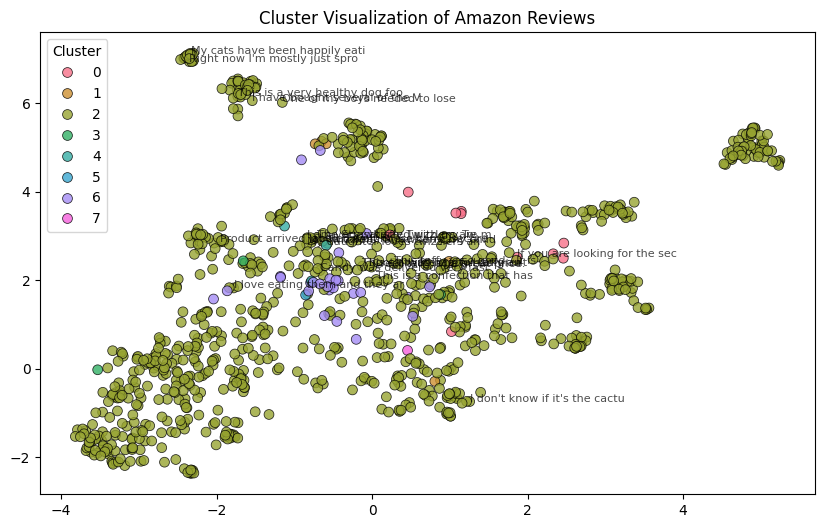

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP

# Reduce embeddings to 2D using UMAP (better than t-SNE for large datasets)
reducer = UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# Convert cluster labels to colors
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Ignore noise points if using DBSCAN/HDBSCAN
palette = sns.color_palette("husl", num_clusters)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], 
    hue=labels, palette=palette, s=50, alpha=0.8, edgecolor='k'
)

# Label some points for reference
for i, txt in enumerate(narratives[:20]):  # Label first 20 points
    plt.annotate(txt[:30], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.title("Cluster Visualization of Amazon Reviews")
plt.legend(title="Cluster")
plt.show()
